In [39]:
import numpy as np
from scipy.linalg import eigh
from openfermion.utils import hermitian_conjugated as hc

from itertools import product
from scipy.linalg import eigh, eigvals
import scipy

from tangelo.linq import get_backend, Circuit, Gate
from tangelo.toolboxes.operators import QubitOperator, count_qubits
from tangelo.toolboxes.qubit_mappings.statevector_mapping import vector_to_circuit
from tangelo.toolboxes.ansatz_generator.ansatz_utils import controlled_pauliwords, trotterize

from tangelo import SecondQuantizedMolecule
from tangelo.algorithms import FCISolver, CCSDSolver, VQESolver
from tangelo.toolboxes.operators import FermionOperator
from tangelo.toolboxes.qubit_mappings.mapping_transform import fermion_to_qubit_mapping as f2q_mapping

In [40]:
algorithm_resources = {}

# Set Hamiltonian parameters for LiH simulation in active space.
# diatomic_bond_length = 1.5949
diatomic_bond_length = 1.547
geometry = [('Li', (0., 0., 0.)), ('H', (0., 0., diatomic_bond_length))]
basis = 'sto-3g'
multiplicity = 1
active_space_start = 1
active_space_stop = 3

mol_LiH = SecondQuantizedMolecule(geometry, symmetry=True)# , q=0, spin=0, basis="sto-3g")

## Multi-Reference Selected Quantum Krylov (MRSQK)
The multi-reference selected Quantum Krylov algorithm as outlined in [arXiv:1911.05163](https://arxiv.org/abs/1911.05163) uses multiple reference states and performs multiple time evolutions $U = e^{-iH\tau}$ for time $\tau$, to generate a Krylov representation of the system. The method relies on building two matrices ${\cal{H}}$ and $S$, whose elements are defined by ${\cal{H}_{ia,jb}} = \left<\phi_a\right|U^i H U^j\left|\phi_b\right>$ and $S_{ia,jb} = \left<\phi_a\right|U^i U^j\left|\phi_b\right>$, where $\phi_a, \phi_b$ denote different reference configurations. The matrix elements are measured using the procedure outlined in [arXiv:1911.05163](https://arxiv.org/abs/1911.05163) and the energies obtained through solving ${\cal{H}}V = SVE$.

In [arXiv:2109.06868](https://arxiv.org/abs/2109.06868), it was further noticed that one can use any function of $\cal{H}$ to obtain the eigenvalues. For example, one could use $f({\cal{H}})=e^{-iH\tau}=U$. The same procedure results in the matrix elements $f({\cal{H}})_{ia,jb} = \left<\phi_a\right|U^i U U^j\left|\phi_b\right>, S_{ia,jb} = \left<\phi_a\right|U^i U^j\left|\phi_b\right>$ for the eigenvalue problem $f({\cal{H}})V=SVf(E)$. As $E$ is a diagonal matrix, the correct energies can be obtained by calculating the phase of the eigenvalues ($f(E)=e^{-iE\tau}$) and dividing by $\tau$. (i.e. $\arctan \left[\Im(f(E))/\Re(f(E)) \right]/\tau$). The resulting circuit is slightly longer but much fewer measurements are required. It is worth mentioning that [qubitization](https://arxiv.org/abs/1610.06546), which natively implements $e^{i \arccos(H\tau)}$, can be used without issue. Qubitization is currently one of the most efficient algorithms that implements time-evolution.

In [122]:
class MRSQKSimulator:
    def __init__(self, mol: SecondQuantizedMolecule, mapping = 'jw'):
        # Number of Krylov vectors
        self.n_krylov = 4
        
        # Qubit Mapping
        self.mapping = mapping
        # mapping = 'BK'
        # mapping = 'scBK'

        # Molecule
        self.mol = mol
        # Qubit operator for LiH
        self.qu_op =  f2q_mapping(mol.fermionic_hamiltonian, mapping, mol.n_active_sos,
                                mol.n_active_electrons, up_then_down=False, spin=mol.spin)
        self.backend = get_backend()

        self.c_q = count_qubits(self.qu_op)
        print(f"Qubit count: {self.c_q+1}, control qubit: {self.c_q}")

        self.zeroone = (QubitOperator(f"X{self.c_q}", 1) + QubitOperator(f"Y{self.c_q}", 1j))

        # Generate multiple controlled-reference states.
        self.reference_states: list[Circuit] = list()
        reference_vecs = [[1, 1, 0, 0], [1, 0, 0, 1]]
        for vec in reference_vecs:
            circ = vector_to_circuit(vec)
            gates = [Gate("C"+gate.name, target=gate.target, control=self.c_q) for gate in circ]
            self.reference_states += [Circuit(gates)]
        
    def simulate(self, t_end: float) -> np.array:
        # Controlled time-evolution of qu_op
        c_trott = trotterize(self.qu_op, time=t_end, control=self.c_q) # n_trotter_steps=1, trotter_order=1

        # Calculate MRSQK
        sab = np.zeros((self.n_krylov, self.n_krylov), dtype=complex)
        # hab = np.zeros((self.n_krylov, self.n_krylov), dtype=complex)
        fhab = np.zeros((self.n_krylov, self.n_krylov), dtype=complex)

        for a, b in product(range(self.n_krylov), range(self.n_krylov)):
            # Generate Ua and Ub unitaries
            ua = self.reference_states[a%2] + c_trott * (a//2) if a > 1 else self.reference_states[a%2]
            ub = self.reference_states[b%2] + c_trott * (b//2) if b > 1 else self.reference_states[b%2]
            
            # Build circuit from Figure 2 for off-diagonal overlap
            hab_circuit = Circuit([Gate("H", self.c_q)]) + ua + Circuit([Gate("X", self.c_q)]) + ub

            # hab_circuit.remove_small_rotations()
            # hab_circuit.remove_redundant_gates()
            # hab_circuit.simplify()

            sab[a, b] = self.backend.get_expectation_value(self.zeroone, hab_circuit) / 2
            sab[b, a] = sab[a, b].conj()

            # Hamiltonian matrix element for f(H) = e^{-i H \tau}
            fhab[a, b] = self.backend.get_expectation_value(self.zeroone, hab_circuit+c_trott.inverse())/2

            # print(hab_circuit.counts_n_qubit)

            # # Return statevector for faster calculation of Hamiltonian matrix elements
            # _ , initial_state = backend.simulate(hab_circuit, return_statevector=True)
            # for i, (term, coeff) in enumerate(qu_op.terms.items()):

            #     # From calculated statevector append controlled-pauliword for each term in Hamiltonian and measure zeroone
            #     expect = coeff*backend.get_expectation_value(zeroone, c_qu[i], initial_statevector=initial_state) / 2

            #     # Add term to sum
            #     hab[a, b] += expect

        # algorithm_resources["mrsqk"] = dict()
        # algorithm_resources["mrsqk"]["qubit_hamiltonian_terms"] = 0
        # algorithm_resources["mrsqk"]["circuit_2qubit_gates"] = hab_circuit.counts.get("CNOT", 0)
        # algorithm_resources["mrsqk"]["n_post_terms"] = n_krylov**2
        # e, v = scipy.linalg.eigh(hab, sab)
        # print(f"The HV=SVE energies are {np.real_if_close(np.round(e, 3))}")
        e = eigvals(fhab, sab)
        # print(f"The f(H)V=SVf(E) energies are {np.arctan2(np.imag(e), np.real(e))/tau}")
        return np.arctan2(np.imag(e), np.real(e))/t_end

Qubit count: 11, control qubit: 10


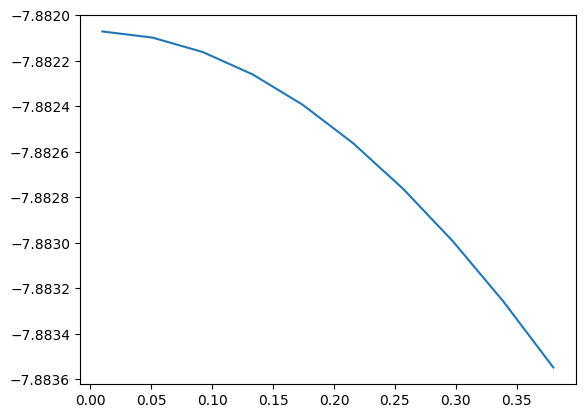

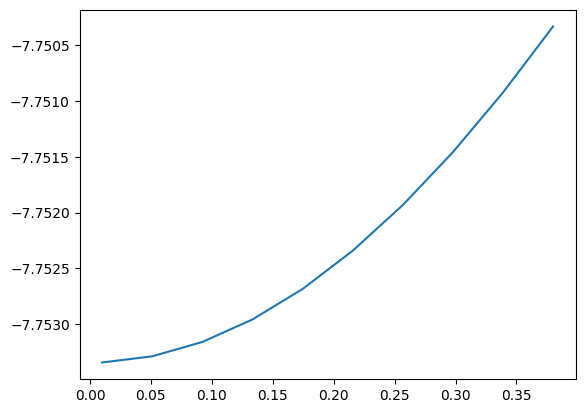

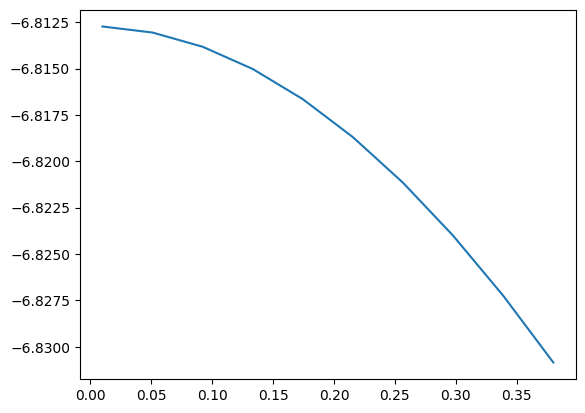

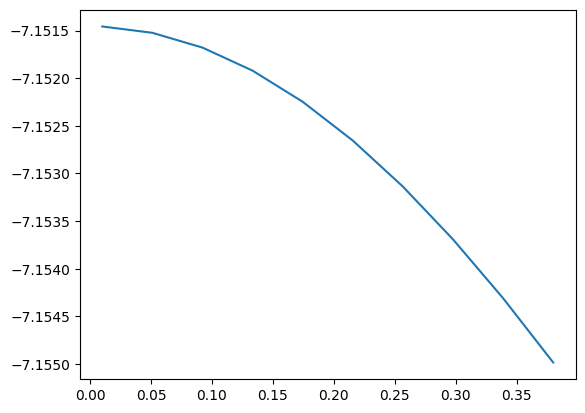

In [126]:
import matplotlib.pyplot as plt

# plot res using the matplotlib library with 4 lines on the same graph over the time np.linspace(0.01, 1.0, 4)
timesteps = np.linspace(0.01, 0.38, 10)
sim = MRSQKSimulator(mol_LiH)
result = np.hstack([np.atleast_2d(sim.simulate(t)).T for t in timesteps])
# result = np.hstack([np.atleast_2d(simulate_molecule(mol_LiH, t)).T for t in timesteps])
# plt.plot(timesteps, *result)
for r in result:
    plt.plot(timesteps, r)
    plt.show()
# plt.show()

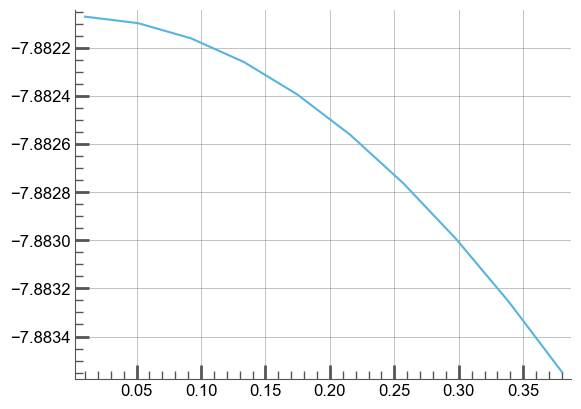

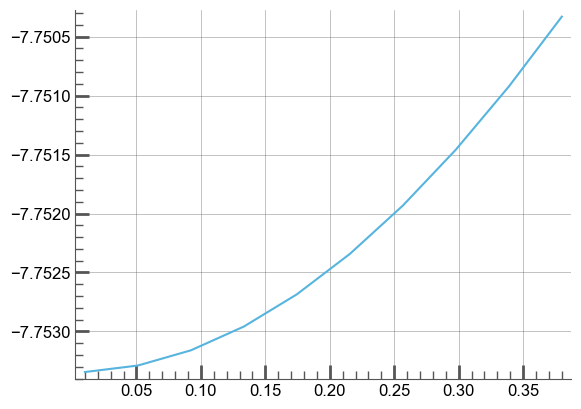

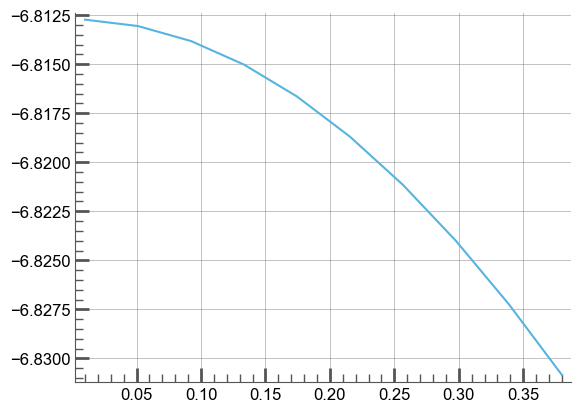

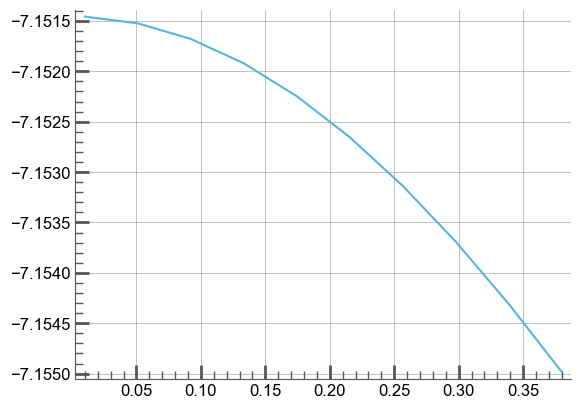

In [134]:
from aquarel import load_theme

with load_theme("scientific"):
    for i, r in enumerate(result):
        plt.plot(timesteps, r)
        plt.savefig(f"mrsqk{i}.svg")
        plt.show()